In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
import sys
# sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks/NLP Projects/Sentiment Analysis')
#from utils import hello

#Libraries

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re,json,nltk
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
path ='/home/ubuntu/Desktop/ML/Coding/dataset/' 
stopwords_list = path+'bangla_stopwords.txt'
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

#Dataset Preparation

In [8]:
# Read the data and take only 1000 Reviews
data = pd.read_csv("/home/ubuntu/Desktop/ML/Coding/dataset/SentNoB Dataset/Train.csv",encoding='utf-8')
df_t = pd.read_csv("/home/ubuntu/Desktop/ML/Coding/dataset/SentNoB Dataset/Test.csv",encoding='utf-8')
data=data.append(df_t);
print("Total Reviews:",len(data),
      "\nTotal Positive Reviews:",len(data[data.Label==2]),
      "\nTotal Neutral Reviews:",len(data[data.Label==1]),
      "\nTotal Negative Reviews:",len(data[data.Label==0]))

Total Reviews: 14161 
Total Positive Reviews: 5119 
Total Neutral Reviews: 5787 
Total Negative Reviews: 3255


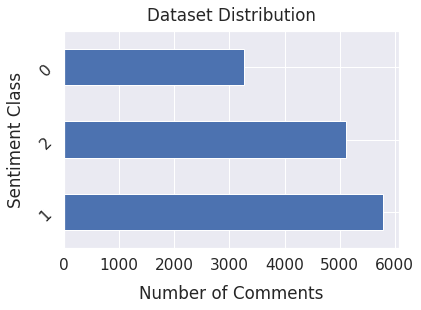

In [9]:
sns.set(font_scale=1.4)
data['Label'].value_counts().plot(kind='barh', figsize=(6, 4))
plt.xlabel("Number of Comments", labelpad=12)
plt.ylabel("Sentiment Class", labelpad=12)
plt.yticks(rotation = 45)
plt.title("Dataset Distribution", y=1.02);

In [10]:
# print some unprocessed reviews
sample_data = [10,100,150,2000,2500,4000,4500,5000,6000,6500,6660,6899,6400,7000,7500,8000]
for i in sample_data:
      print(data.Data[i],'\n','Sentiment:-- ',data.Label[i],'\n')  

10    লেসবো মেয়েটার ফ্রেন্ড টা অনেক কিউট 
10        আমার পছন্দ সাদা ভা আর গরুর মাংস
Name: Data, dtype: object 
 Sentiment:--  10    2
10    0
Name: Label, dtype: int64 

100    ভর দুপুরে এত খাবার দেখে ভীষণ লোভ লাগল দাদা , দ...
100      না দা ভাগাড়ের মরা মুরগী বা পাঙ্গাস নয় আসল ভেটকী
Name: Data, dtype: object 
 Sentiment:--  100    1
100    1
Name: Label, dtype: int64 

150    সাধারণ মানুষদের থেকে ও তারা এভাবে খাই । পুলিশ ...
150            নাইফ তো কাচা বিফের ভিতর ও ইজিলি ঢুকে যাবে
Name: Data, dtype: object 
 Sentiment:--  150    2
150    1
Name: Label, dtype: int64 

ভাই আপনাকে পাঞ্জাবিতে বেশি ভালো মানায় 
 Sentiment:--  1 

তোমার জন্য অনেক দোয়া এবং শুভ কামনা  
 Sentiment:--  1 

ব্যাংকক ফুড টুর খুব ভাল লাগল । অাপনার প্রেজেনটেশন খুব এনারজেটিক হয়েছে 
 Sentiment:--  1 

রহস্যময় পৃথিবী ভদ্রভাবে কথা বলছি ভাল লাগছে না ? শুকর খাবি ? স্ট্যাক করে খাইতে পারবি । একদম সফট মিট । বোনলেস 
 Sentiment:--  2 

যারা প্রাণীজ আমিষ খায় না , শাক থেকে সবজি তাদের জন্য ঠিক আছে , এর বাইরে উপায়ও নেই কোন ! কিন্

#Data Cleaning

In [11]:
# Data cleaning function
def process_comments(comment): 
    comment = re.sub('[^\u0980-\u09FF]',' ',str(comment)) #removing unnecessary punctuation
    return comment

In [12]:
# Apply the function into the dataframe
data['cleaned'] = data['Data'].apply(process_comments)  

# print some cleaned reviews from the dataset
sample_data = [10,100,150,2000,2500,4000,4500,5000,6000,6500,6660,6899,6400,7000,7500,8000]
for i in sample_data:
     print('Original:\n',data.Data[i],'\nCleaned:\n',
           data.cleaned[i],'\n','Sentiment:-- ',data.Label[i],'\n')

Original:
 10    লেসবো মেয়েটার ফ্রেন্ড টা অনেক কিউট 
10        আমার পছন্দ সাদা ভা আর গরুর মাংস
Name: Data, dtype: object 
Cleaned:
 10    লেসবো মেয়েটার ফ্রেন্ড টা অনেক কিউট 
10        আমার পছন্দ সাদা ভা আর গরুর মাংস
Name: cleaned, dtype: object 
 Sentiment:--  10    2
10    0
Name: Label, dtype: int64 

Original:
 100    ভর দুপুরে এত খাবার দেখে ভীষণ লোভ লাগল দাদা , দ...
100      না দা ভাগাড়ের মরা মুরগী বা পাঙ্গাস নয় আসল ভেটকী
Name: Data, dtype: object 
Cleaned:
 100    ভর দুপুরে এত খাবার দেখে ভীষণ লোভ লাগল দাদা   দ...
100      না দা ভাগাড়ের মরা মুরগী বা পাঙ্গাস নয় আসল ভেটকী
Name: cleaned, dtype: object 
 Sentiment:--  100    1
100    1
Name: Label, dtype: int64 

Original:
 150    সাধারণ মানুষদের থেকে ও তারা এভাবে খাই । পুলিশ ...
150            নাইফ তো কাচা বিফের ভিতর ও ইজিলি ঢুকে যাবে
Name: Data, dtype: object 
Cleaned:
 150    সাধারণ মানুষদের থেকে ও তারা এভাবে খাই   পুলিশ ...
150            নাইফ তো কাচা বিফের ভিতর ও ইজিলি ঢুকে যাবে
Name: cleaned, dtype: object 
 Sentiment:--  150    

##Remove Low lenght data

In [13]:
# Length of each Reveiws
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
# Remove the reviews with least words
dataset = data.loc[data.length>2]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Reviews".format(len(data)-len(dataset)),
      "\nTotal Reviews:",len(dataset))

After Cleaning: 
Removed 8 Small Reviews 
Total Reviews: 14153


#Dataset Summary

In [14]:
def data_summary(dataset):
    
    """
    This function will print the summary of the reviews and words distribution in the dataset. 
    
    Args:
        dataset: list of cleaned sentences   
        
    Returns:
        Number of documnets per class: int 
        Number of words per class: int
        Number of unique words per class: int
    """
    documents = []
    words = []
    u_words = []
    total_u_words = [word.strip().lower() for t in list(dataset.cleaned) for word in t.strip().split()]
    class_label= [k for k,v in dataset.Label.value_counts().to_dict().items()]
  # find word list
    for label in class_label: 
        word_list = [word.strip().lower() for t in list(dataset[dataset.Label==label].cleaned) for word in t.strip().split()]
        counts = dict()
        for word in word_list:
                counts[word] = counts.get(word, 0)+1
        # sort the dictionary of word list  
        ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
        # Documents per class
        documents.append(len(list(dataset[dataset.Label==label].cleaned)))
        # Total Word per class
        words.append(len(word_list))
        # Unique words per class 
        u_words.append(len(np.unique(word_list)))
       
        print("\nClass Name : ",label)
        print("Number of Documents:{}".format(len(list(dataset[dataset.Label==label].cleaned))))  
        print("Number of Words:{}".format(len(word_list))) 
        print("Number of Unique Words:{}".format(len(np.unique(word_list)))) 
        print("Most Frequent Words:\n")
        for k,v in ordered[:10]:
              print("{}\t{}".format(k,v))
    print("Total Number of Unique Words:{}".format(len(np.unique(total_u_words))))           
   
    return documents,words,u_words,class_label

#call the fucntion
documents,words,u_words,class_names = data_summary(dataset)    



Class Name :  1
Number of Documents:5786
Number of Words:83035
Number of Unique Words:13945
Most Frequent Words:

না	1141
ভাই	1120
আপনার	865
ভালো	842
অনেক	827
আর	712
করে	682
জন্য	677
আমি	670
এই	637

Class Name :  2
Number of Documents:5119
Number of Words:77180
Number of Unique Words:13147
Most Frequent Words:

না	2319
আর	887
এই	873
করে	860
কি	750
পুলিশ	567
হয়	490
তো	439
ভাই	410
টাকা	400

Class Name :  0
Number of Documents:3248
Number of Words:38398
Number of Unique Words:9214
Most Frequent Words:

না	1293
কি	432
ভাই	421
করে	322
আর	317
এই	302
থেকে	258
হয়	248
আমি	244
হবে	217
Total Number of Unique Words:25528


#Dataset Summary Visualization

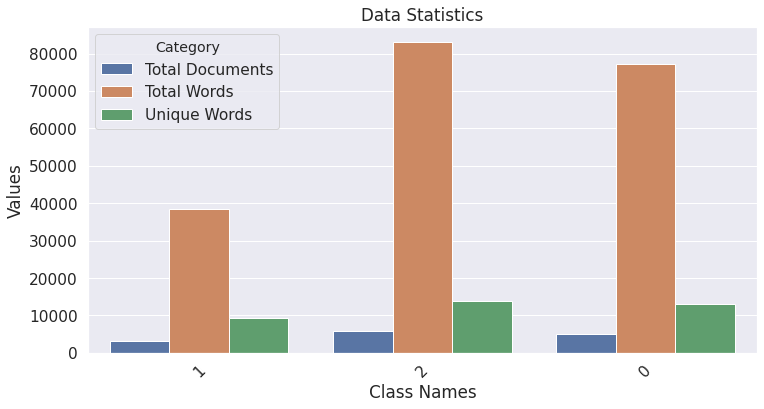

In [15]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':u_words,
                            'Class Names':class_names})
df = pd.melt(data_matrix, id_vars="Class Names", var_name="Category", value_name="Values")
plt.figure(figsize=(12, 6))
ax = plt.subplot()

sns.barplot(data=df,x='Class Names', y='Values' ,hue='Category')
ax.set_xlabel('Class Names') 
ax.set_title('Data Statistics')

ax.xaxis.set_ticklabels(class_names, rotation=45);

#Comment Lenght Distribution

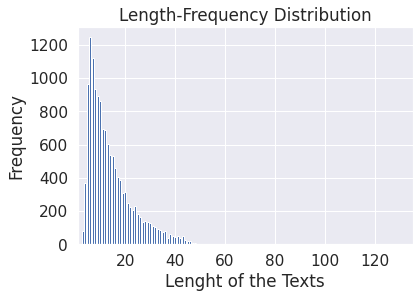

Maximum Length of a review: 57
Minimum Length of a review: 3
Average Length of a reviews: 14.0


In [16]:
# Calculate the Review of each of the Review
dataset['ReviewLength'] = dataset.cleaned.apply(lambda x:len(x.split()))
frequency = dict()
for i in dataset.ReviewLength:
    frequency[i] = frequency.get(i, 0)+1

plt.bar(frequency.keys(), frequency.values(), color ="b")
plt.xlim(1, 135)
# in this notbook color is not working but it should work.
plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()  
print(f"Maximum Length of a review: {max(dataset.ReviewLength)}")
print(f"Minimum Length of a review: {min(dataset.ReviewLength)}")
print(f"Average Length of a reviews: {round(np.mean(dataset.ReviewLength),0)}")

# Take only Positive and Negative Class for Model Building

In [17]:
# #dataset.Tag = dataset.Tag.replace({'Very Positive':'Positive','Very Negative':'Negative'})
# positive = dataset[dataset.Label == 2]
# #nuetral = dataset[dataset.Label == 1]
# negative = dataset[dataset.Label == 0]
# dataset = positive.append(negative,ignore_index=True)
# #dataset = dataset.append(nuetral,ignore_index=True)
# dataset.Label.value_counts()


dataset.Label = dataset.Label.replace({1:2})
dataset.Label.value_counts()


2    10905
0     3248
Name: Label, dtype: int64

##Lable Encoding and Dataset Splitting

In [18]:
                                      #==================================================
                                       ################# Label Encoding Function #########
                                       #==================================================

def label_encoding(sentiment,bool):
    """
    This function will return the encoded labels in array format. 
    
    Args:
        sentiment: series of class names(str)
        bool: boolean (True or False)
        
    Returns:
        labels: numpy array 
    """
    le = LabelEncoder()
    le.fit(sentiment)
    encoded_labels = le.transform(sentiment)
    labels = np.array(encoded_labels) # Converting into numpy array
    class_names =le.classes_ ## Define the class names again
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(sentiment[i],' ', encoded_labels[i],'\n')

    return labels



                           #===========================================================
                           ################# Dataset Splitting Function ###############
                           #=========================================================== 

def dataset_split(feature_space,sentiment):
    """
    This function will return the splitted (80%-20%) feature vector . 
    
    Args:
        feature_space: calcuated feature vector (sparse matrix)
        sentiment: encoded lables (array) 
        
    Returns:
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
    """

    X_train,X_test,y_train,y_test = train_test_split(feature_space,sentiment,train_size = 0.9,
                                                  test_size = 0.1,random_state =0)
    
#     X_train=feature_space[:12570]
#     X_test=sentiment[12570:]
#     y_train=feature_space[:12570]
#     y_test=sentiment[12570:]
    
    
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])
  
    return X_train,X_test,y_train,y_test


In [19]:
dataset.cleaned = dataset.cleaned.apply(lambda x:x.replace('\n',' '))

#**Model Building Using Machine Learning**

##Feature Extraction Using TF-IDF

In [20]:
                                            #======================================
                                            ##### Unigram Tf-idf value calculation
                                            #======================================
            
def calc_gram_tfidf(reviews,gram):
    """
    This function will return the tf-idf value of the respective gram features . 
    
    Args:
        reviews: a list of cleaned reviews   
        
    Returns:
        tfidf: a instance of TfidfVectorizer
        X : Unigram Feature Vector (sparse matrix)
    """
    tfidf = TfidfVectorizer(ngram_range=gram,use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(reviews)
    
    return tfidf,X


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve


In [22]:
                                              #============================================
                                              #########  Classifiers Defination  #########
                                              #============================================
def ml_models_defination(): 
    """
    This function consists the models defination for All gram Features
    
    Retuns:
        ml_models: list of models
        model_names: list of model_names
    
    """
    
    lr_model = LogisticRegression(random_state = 123)
    dt_model = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    rf_model = RandomForestClassifier(n_estimators=100, criterion ='entropy', random_state = 0)
    mnb_model = MultinomialNB(alpha=0.15)
    knn_model = KNeighborsClassifier(n_neighbors=3, metric = 'minkowski')
    lsvm_model = SVC(kernel = 'linear',C = 0.2, probability=True, random_state = 0)
    ksvm_model = SVC(C= 1000,kernel = 'rbf',probability=True, gamma = 0.00015, random_state = 0)
    model_names = ['Logistic Regression','Decision Tree','Random Forest','Naive Bayes','KNN','Linear SVM','Kernel SVM']
    #model_names = ['Logistic Regression']
    # Create list of models
    ml_models = [lr_model,dt_model,rf_model,mnb_model,knn_model,lsvm_model,ksvm_model]
    #ml_models = [lr_model]
    return ml_models,model_names 


                                          #============================================
                                           ####### Model Evaluation Function ############
                                           #=============================================

def model_performace(model,X_train,X_test,y_train,y_test):
    """
    This function will return the performance parameter values of each ML models.
    Performance parameters are Accuracy, F1-Score, Precision, Recall.
    
    Args:
        model: a ML model instance
        X_train: training feature vector (sparse matrix)
        X_test : testing feature vector (sparse matrix)
        y_train: training encoded labels (array) 
        y_test : testing encoded labels (array) 
        
    Returns:
        my_dict: a dictionary of all the parameters for each models
    """
    my_dict = {}
    model.fit(X_train,y_train)
    # Prediction
    pred_y = model.predict(X_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100 
    my_dict['Precision'] = round(precision_score(y_test, pred_y),4)*100 
    my_dict['Recall'] = round(recall_score(y_test, pred_y),4)*100 
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y),4)*100 
    
    return my_dict  

                                        #========================================
                                        #### Model Performane into Dataframe #####
                                        #=========================================
            
def performance_table(performance_dict):
    """
    This function will create a dataframe of all the performance parameters.
    
    Args:
        performance_dict: a dictionary of all the parameters for each models
        
    Returns:
        performance_df: a dataframe
    """

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])

    # Create a dataframe
    model_names = ['LR','DT','RF','MNB','KNN','Linear SVM','RBF SVM']
    performance_df = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list,
                                   'Model Name':model_names })
    return performance_df    

##Model Training

In [23]:
## save the performance of the model for each gram feature 
gram_names = ['Unigram','Bigram','Trigram']
ngrams = [(1,1),(1,2),(1,3)]
for i,gram in enumerate(ngrams):
    tfidf,feature = calc_gram_tfidf(dataset.cleaned,gram)
    labels = label_encoding(dataset.Label,False)
    X_train,X_test,y_train,y_test = dataset_split(feature,labels)
    
    print("\n\n label: ",y_train)
    
    l1=0
    l2=0
    l0=0
    
    for x in y_train:
        if x==1:
            l1=l1+1
        if x==2:
            l2=l2+1
        else:
            l0=l0+1
    print("\nl0 : ",l0,"  l1: ",l1,"  l2: ",l2,"\n")
    
    l1=0
    l2=0
    l0=0
    
    for x in y_test:
        if x==1:
            l1=l1+1
        if x==2:
            l2=l2+1
        else:
            l0=l0+1
            
    print("\nl0 : ",l0,"  l1: ",l1,"  l2: ",l2,"\n")
    
    ml_models,model_names = ml_models_defination()
    # call model accuracy function and save the metrices into a dictionary
    accuracy = {f'{model_names[j]}':model_performace(model,X_train,X_test,y_train,y_test) for j,model in enumerate(ml_models)}
    #Save the performance parameter into json file
    with open(path+f'ml_performance_{gram_names[i]}.json', 'w') as f:
          json.dump(accuracy, f)

Feature Size :======> 25528

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 14153 
	Training		 12737 
	Test			 1416


 label:  [1 1 0 ... 1 1 1]

l0 :  12737   l1:  9812   l2:  0 


l0 :  1416   l1:  1093   l2:  0 

Feature Size :======> 140104

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 14153 
	Training		 12737 
	Test			 1416


 label:  [1 1 0 ... 1 1 1]

l0 :  12737   l1:  9812   l2:  0 


l0 :  1416   l1:  1093   l2:  0 

Feature Size :======> 277696

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 14153 
	Training		 12737 
	Test			 1416


 label:  [1 1 0 ... 1 1 1]

l0 :  12737   l1:  9812   l2:  0 


l0 :  1416   l1:  1093   l2:  0 



##Performance Table

In [24]:
# Load all the json files
gram_names = ['Unigram','Bigram','Trigram']

for gram in gram_names:
  accuracy = json.load(open(path+f'ml_performance_{gram}.json'))
  table = performance_table(accuracy)
  print(f"\n========== Performace Table for {gram} feature:========\n",table)
  print(f"\n========In case of {gram} feature:========\n")
  print(f"Highest Accuracy achieved by {table['Model Name'][table.Accuracy.idxmax(axis = 0)]} at = {max(table.Accuracy)}")
  print(f"Highest F1-Score achieved by {table['Model Name'][table['F1 Score'].idxmax(axis = 0)]} at = {max(table['F1 Score'] )}")
  print(f"Highest Precision Score achieved by {table['Model Name'][table['Precision'].idxmax(axis = 0)]} at = {max(table['Precision'] )}")
  print(f"Highest Recall Score achieved by {table['Model Name'][table['Recall'].idxmax(axis = 0)]} at = {max(table['Recall'] )}")
  


========== Performace Table for Unigram feature:========
    Accuracy  Precision  Recall  F1 Score  Model Name
0     78.32      78.44   99.18     87.60          LR
1     73.09      81.28   84.63     82.92          DT
2     80.51      80.69   98.26     88.61          RF
3     78.11      81.35   92.96     86.76         MNB
4     75.14      82.08   86.73     84.34         KNN
5     77.19      77.19  100.00     87.13  Linear SVM
6     77.19      77.19  100.00     87.13     RBF SVM

========In case of Unigram feature:========

Highest Accuracy achieved by RF at = 80.51
Highest F1-Score achieved by RF at = 88.61
Highest Precision Score achieved by KNN at = 82.08
Highest Recall Score achieved by Linear SVM at = 100.0

========== Performace Table for Bigram feature:========
    Accuracy  Precision  Recall  F1 Score  Model Name
0     77.61      77.71   99.54     87.28          LR
1     76.69      82.47   88.66     85.45          DT
2     80.51      80.42   98.81     88.67          RF
3     76.

**Conclusion:**

---



***From this performance table it can be said that the Trigarm feature combination with Multinomial Naive Bayes classifier provides highest accuray and F1-score value.***

## Performance Visualization

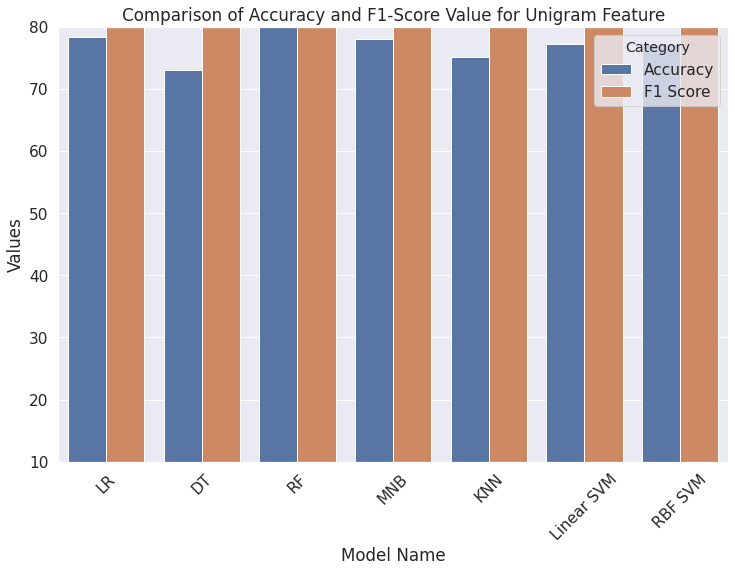

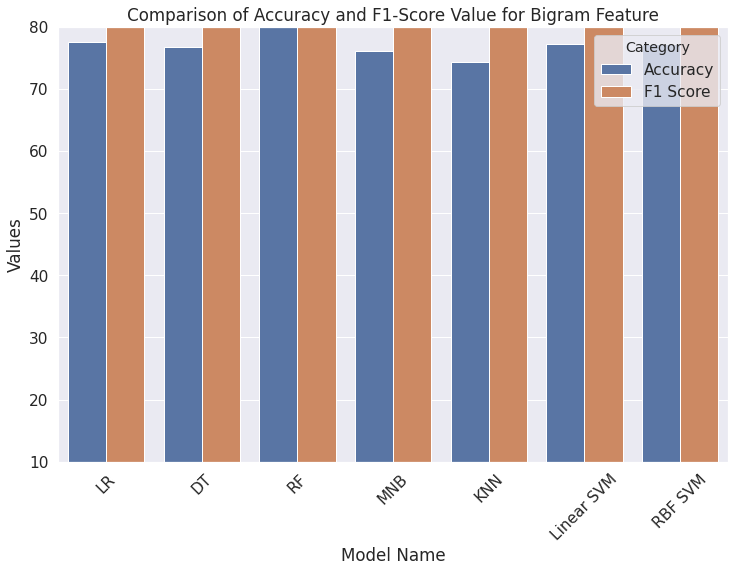

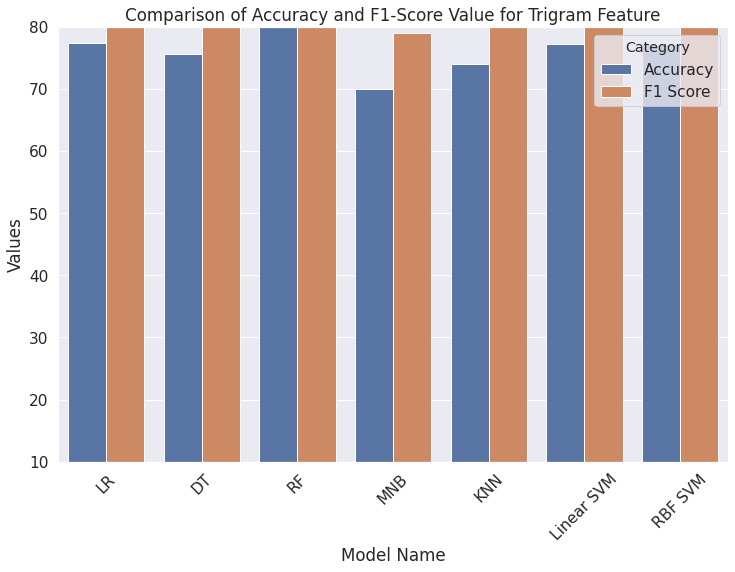

In [25]:
gram_names = ['Unigram','Bigram','Trigram']

for gram in gram_names:
  accuracy = json.load(open(path+f'ml_performance_{gram}.json'))
  table = performance_table(accuracy)
  df = pd.melt(table[['Accuracy','F1 Score','Model Name']], id_vars="Model Name", var_name="Category", value_name="Values")
  plt.figure(figsize=(12,8))
  ax = plt.subplot()
  sns.barplot(data=df,x='Model Name', y='Values' ,hue='Category')
  ax.set_xlabel('Model Name') 
  ax.set_title(f'Comparison of Accuracy and F1-Score Value for {gram} Feature')
  ax.set_ylim([10,80])
  ax.xaxis.set_ticklabels(table['Model Name'], rotation=45);